In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
gs = pd.read_csv("annotated_DK_gold.tsv", delimiter = "\t", encoding = "utf-16le", usecols = [0,1,2,3,4,5], 
                names = ["ID", "Sentiment", "Speech", "Annotation", "Note", "2nd Annot"], dtype = object).dropna(subset = "Annotation")[:300]

In [3]:
gs.head()

,ID,Sentiment,Speech,Annotation,Note,2nd Annot
0,ParlaMint-DK_20181211164251,0.032793919436741065,"Tak for det , og tak til ministeren for den he...",0,NaN,0
1,ParlaMint-DK_20151120124908,0.012924618611370906,"Det handler vel om , om vi lader befolkningen ...",-1,NaN,-1
2,ParlaMint-DK_20201210104545,0.009549047072178355,"Jeg skal beklage , hvis jeg har formuleret mig...",1,NaN,0
3,ParlaMint-DK_20191211150548,0.0222902005448092,Tak for spørgsmålet og interessen for vores fo...,-1,NaN,-1
4,ParlaMint-DK_20220128115928,-0.009523809523809525,Fru Kathrine Olldag fra Det Radikale Venstre s...,-1,NaN,-2


In [4]:
gs["Sentiment"] = gs["Sentiment"].astype(float)
gs["Annotation"] = gs["Annotation"].astype(float)
gs["2nd Annot"] = gs["2nd Annot"].astype(float)

In [5]:
gs["Annotation"].mean()

-0.09

### Histograms

<AxesSubplot:>

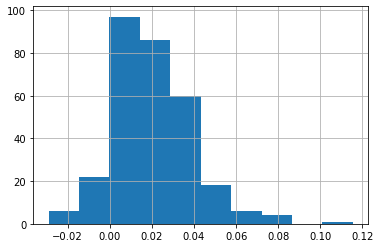

In [6]:
gs["Sentiment"].hist()

In [7]:
data = gs['Annotation'].value_counts().sort_index()

<AxesSubplot:>

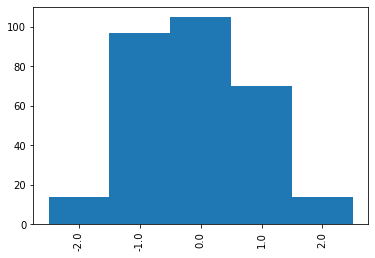

In [8]:
data.plot(kind='bar', width=1.0)

<AxesSubplot:>

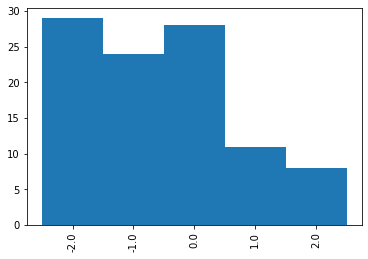

In [9]:
 gs["2nd Annot"].value_counts().sort_index().plot(kind = "bar", width = 1.0)

### Interannotator agreement

In [10]:
import sklearn
from sklearn.metrics import cohen_kappa_score

/Users/yananikolova/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
#fair/slight agreement
cohen_kappa_score(gs["Annotation"][:100], gs["2nd Annot"][:100])

0.4008922880815806

In [12]:
#how about with three categories?

negative = gs["Annotation"].isin([-2, -1])
positive = gs["Annotation"].isin([2, 1])
neutral = gs["Annotation"] == 0

gs["Minimal"] = pd.Series(dtype = float)
gs["Minimal"] = gs["Minimal"].mask(negative, other = -1)
gs["Minimal"] = gs["Minimal"].mask(positive, other = 1)
gs["Minimal"] = gs["Minimal"].mask(neutral, other = 0)

In [13]:
negative = gs["2nd Annot"].isin([-2, -1])
positive = gs["2nd Annot"].isin([2, 1])
neutral = gs["2nd Annot"] == 0

gs["2nd Minimal"] = pd.Series(dtype = float)
gs["2nd Minimal"] = gs["2nd Minimal"].mask(negative, other = -1)
gs["2nd Minimal"] = gs["2nd Minimal"].mask(positive, other = 1)
gs["2nd Minimal"] = gs["2nd Minimal"].mask(neutral, other = 0)

In [14]:
#fair/moderate agreement
cohen_kappa_score(gs["Minimal"][:100], gs["2nd Minimal"][:100])

0.6641074856046065

In [15]:
#confusion matrix 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(gs["Minimal"][:100], gs["2nd Minimal"][:100])


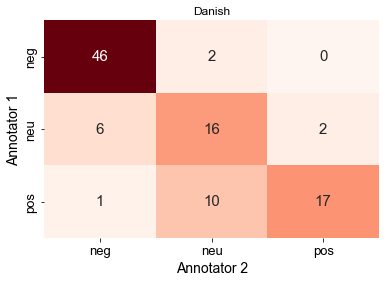

In [16]:
import seaborn as sns

ax= plt.subplot()
sns.set(font_scale=1)

sns.set (rc = {'figure.figsize':(4,4)})
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = "Reds", cbar = False, annot_kws={"fontsize":15});  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Annotator 2', fontsize = 14);
ax.set_ylabel('Annotator 1', fontsize = 14); 
ax.set_title('Danish');
ax.xaxis.set_ticklabels(['neg', 'neu', 'pos'], fontsize = 13); 
ax.yaxis.set_ticklabels(['neg', 'neu', 'pos'], fontsize = 13);

## Correlation

In [17]:
from sklearn.feature_selection import r_regression
from sklearn.metrics import r2_score


In [16]:
r_regression(gs["Annotation"].to_numpy().reshape(-1, 1), gs["Sentiment"])

array([0.47745481])

In [18]:
r2_score(gs["Annotation"].to_numpy().reshape(-1, 1), gs["Sentiment"])

0.005321598643730718

In [25]:
r_regression(gs["Sentiment"].to_numpy().reshape(-1, 1), gs["Annotation"])

array([0.47745481])

In [22]:
r2_score(gs["Sentiment"], gs["Annotation"].to_numpy().reshape(-1, 1))

-2555.258393547546

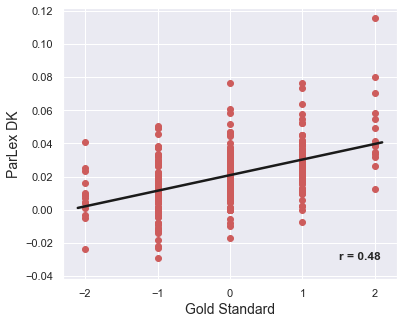

In [19]:
b, a = np.polyfit(gs["Annotation"], gs["Sentiment"], deg=1)
xseq = np.linspace(-2.1,2.1,50)
plt.rcParams["figure.figsize"] = (6,5)
plt.grid(zorder = -3.0)


plt.scatter(gs["Annotation"], gs["Sentiment"], color = "indianred", alpha = 1, zorder = 2.0)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.text(1.5, -0.03, "r = 0.48", fontsize = 12, weight = "bold")
plt.ylim(-0.042, 0.122)
plt.xlabel("Gold Standard", fontsize = 14)
plt.ylabel("ParLex DK", fontsize = 14)
#plt.title("Danish")
plt.show()

In [20]:
gs.groupby(["Annotation"])["Sentiment"].mean()

Annotation
-2.0    0.008454
-1.0    0.010842
 0.0    0.020616
 1.0    0.028275
 2.0    0.049068
Name: Sentiment, dtype: float64

In [21]:
r_regression(gs[~(gs["Note"] == "sarcasm")]["Annotation"].to_numpy().reshape(-1, 1), gs[~(gs["Note"] == "sarcasm")]["Sentiment"])

array([0.48739395])

In [30]:
(gs["Note"] == "sarcasm").sum()

8

## Comparison to AFINN

In [63]:
plt.rcdefaults()

In [64]:
afinn = pd.read_csv("afinn_dk.txt", del1imiter = "\t", names = ["Word", "Score"])
finndict = dict(zip(afinn["Word"].to_list(), afinn["Score"].to_list()))

In [65]:
negwords = ["ikke", "ingen", "hverken", "aldrig"]
punct = [".", ",", "?", "!"]
skip = False
scores = []
for speech in gs["Speech"]:
    speech = [word.lower() for word in speech.split(" ")]
    score = 0
    for word in speech:
        if word in negwords:
            skip = True
        elif word in punct:
            skip = False
            
        if skip == False:
            score += int(finndict.get(word, 0))
    scores.append(score)
    

In [66]:
gs["AFINN"] = scores

<AxesSubplot:>

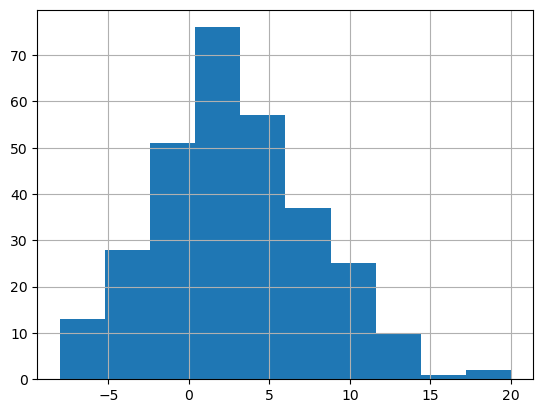

In [67]:
gs["AFINN"].hist()

In [68]:
r_regression(gs["Sentiment"].to_numpy().reshape(-1, 1), gs["AFINN"])

array([0.5030999])

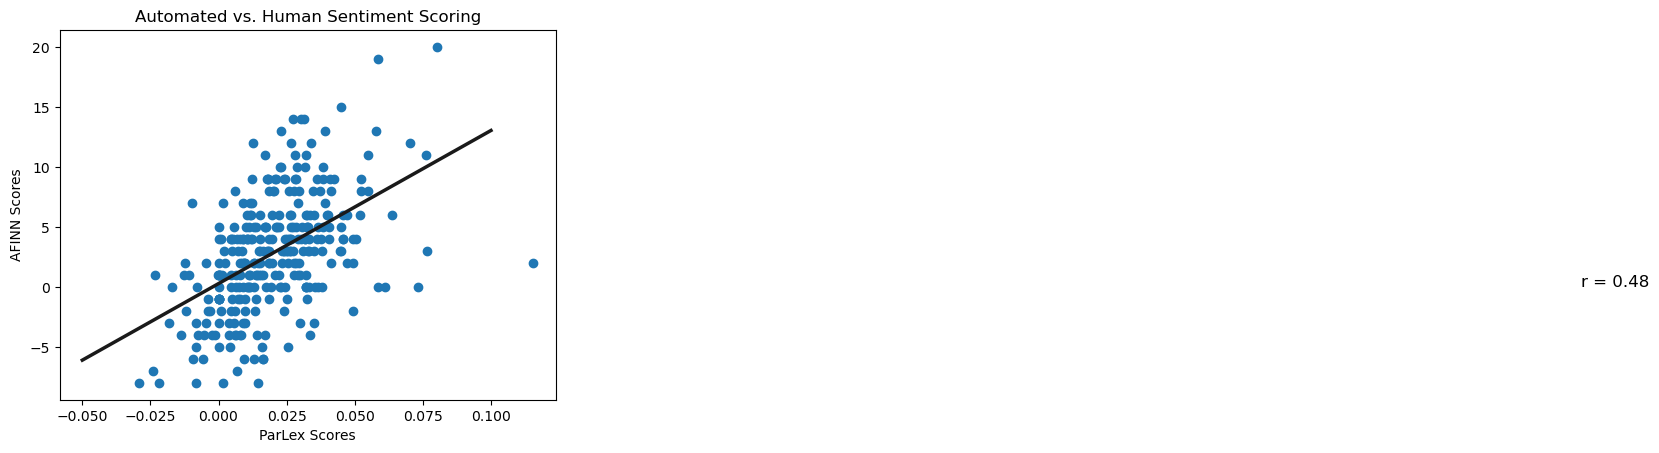

In [69]:
b, a = np.polyfit(gs["Sentiment"], gs["AFINN"], deg=1)
xseq = np.linspace(-0.05, 0.1,50)

plt.scatter(gs["Sentiment"], gs["AFINN"])
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.text(0.5, -0.03, "r = 0.48", fontsize = 12)
plt.xlabel("ParLex Scores")
plt.ylabel("AFINN Scores")
plt.title("Automated vs. Human Sentiment Scoring")
plt.show()

In [70]:
r_regression(gs["Annotation"].to_numpy().reshape(-1, 1), gs["AFINN"])

array([0.55462414])

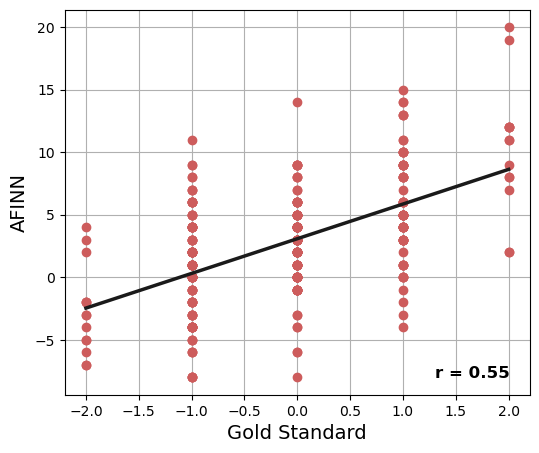

In [76]:


plt.rcParams["figure.figsize"] = (6,5)


b, a = np.polyfit(gs["Annotation"], gs["AFINN"], deg=1)
xseq = np.linspace(-2, 2,50)
plt.grid(zorder = -3.0)



plt.scatter(gs["Annotation"], gs["AFINN"], color = "indianred", alpha = 1, zorder = 2.0)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5);
plt.text(1.3, -8,"r = 0.55",fontsize = 12, weight = "bold")
plt.xlabel("Gold Standard", fontsize = 14)
plt.ylabel("AFINN", fontsize = 14)
#plt.title("Automated vs. Human Sentiment Scoring")
plt.show()

### Overlap

In [51]:
with open("afinn_dk.txt.ord.pos.lem.TABULATOR.txt", "r") as file:
    af = file.readlines()[:-1]

In [59]:
lemmas = []

for line in af:
    line = line.split("\t")
    if len(line) == 3:
        lemma = line[2].rstrip()
        lemmas.append(lemma)

In [69]:
with open('sentdict_pos_DK.txt', 'r') as f:
    poslist = [el.split('\t') for el in f.readlines()]
    
with open('sentdict_neg_DK.txt', 'r') as f:
    neglist = [el.split('\t') for el in f.readlines()]

#aggregate sentiment words and their scores
words = [line[0] for line in poslist] + [line[0] for line in neglist]



In [76]:
len(words) + len(set(lemmas))

3503

In [72]:
len(set(words+lemmas))

3034

In [78]:
1 - 3034/3503

0.1338852412218099

In [83]:
-(3034 - 3503) /len(set(lemmas))

0.2230147408464099

### Do averages match?

In [47]:
df_dk = pd.read_csv("ParlaMint-DK-SENT.csv", delimiter = ",", dtype = object)
df_dk = df_dk[~df_dk["Speaker_party"].isin(["IA", "JF", "SIU", "T", "SP", "NQ", "FG"])]
df_dk = df_dk[df_dk["Speaker_role"]!= "Chairperson"]
df_dk = df_dk.drop(df_dk[(df_dk["Speaker_Minister"] == "-") & (df_dk["Speaker_MP"] == "notMP")].index)

In [48]:
gs_full = gs.set_index("ID").merge(df_dk.set_index("ID"), on = "ID", how = "left")

In [49]:
gs_full.groupby(["Party_status"])["Sentiment_x"].mean()

Party_status
Coalition     0.023060
Opposition    0.018464
Name: Sentiment_x, dtype: float64

In [50]:
gs_full.groupby(["Party_status"])["Annotation"].mean()

Party_status
Coalition     0.043956
Opposition   -0.158273
Name: Annotation, dtype: float64

In [53]:
coal = gs_full[gs_full["Party_status"] == "Coalition"]["Annotation"]
oppo = gs_full[gs_full["Party_status"] == "Opposition"]["Annotation"]

from scipy import stats
stats.ttest_ind(coal, oppo)

Ttest_indResult(statistic=1.5540243965232894, pvalue=0.12156555939952714)

In [54]:
coal = gs_full[gs_full["Party_status"] == "Coalition"]["Sentiment_x"]
oppo = gs_full[gs_full["Party_status"] == "Opposition"]["Sentiment_x"]

from scipy import stats
stats.ttest_ind(coal, oppo)

Ttest_indResult(statistic=1.766920553118697, pvalue=0.0785794086410243)

In [55]:
men = gs_full[gs_full["Speaker_gender"] == "M"]["Annotation"]
women = gs_full[gs_full["Speaker_gender"] == "F"]["Annotation"]

stats.ttest_ind(men, women)

Ttest_indResult(statistic=0.17237786265582353, pvalue=0.8632582749271516)

In [56]:
men = gs_full[gs_full["Speaker_gender"] == "M"]["Sentiment_x"]
women = gs_full[gs_full["Speaker_gender"] == "F"]["Sentiment_x"]

stats.ttest_ind(men, women)

Ttest_indResult(statistic=-1.1648074439999974, pvalue=0.245034823625134)

In [51]:
gs_full.groupby(["Speaker_gender"])["Sentiment_x"].mean()

Speaker_gender
F    0.021942
M    0.019105
Name: Sentiment_x, dtype: float64

In [52]:
gs_full.groupby(["Speaker_gender"])["Annotation"].value_counts()

Speaker_gender  Annotation
F               -1.0          29
                 0.0          25
                 1.0          22
                -2.0           5
                 2.0           4
M                0.0          78
                -1.0          68
                 1.0          48
                 2.0          10
                -2.0           9
Name: Annotation, dtype: int64

In [26]:
gs_full.groupby(["Debate", "Party_status"])["Sentiment_x"].count()

Debate  Party_status
False   Coalition        68
        Opposition      121
True    Coalition        23
        Opposition       18
Name: Sentiment_x, dtype: int64

In [156]:
gs_full.groupby(["Question", "Party_status"])["Sentiment_x"].count()

Question  Party_status
False     Coalition       39
          Opposition      46
True      Coalition       52
          Opposition      93
Name: Sentiment_x, dtype: int64